In [1]:
import os
import pandas as pd
import numpy as np
import csv

from itertools import cycle, product
import argparse
import warnings

from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, RepeatedStratifiedKFold, train_test_split
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.decomposition import NMF
from sklearn.exceptions import ConvergenceWarning

# import private scripts
import load_kmer_cnts_jf
import stats_utils_AEB

#plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
graph_dir = os.environ['HOME'] + '/deep_learning_microbiome/analysis/kmers/linear/'

In [3]:
def vis_NMF(data, n_components=5, init = 'random', solver='mu', beta_loss='frobenius', max_iter=1000, random_state=0, sort = False, title = "dataset"):
    model = NMF(
        n_components = n_components,
        init = init,
        solver = solver, 
        beta_loss = beta_loss,
        max_iter = max_iter, 
        random_state = random_state
    )
    
    #NMF matrixes
    V = data.T
    W = model.fit_transform(V)
    H = model.components_
    print(W.shape)
    print(H.shape)
    
    #Getting it ready for plotting
    W_all = pd.DataFrame(W)
    W_all['Features'] = pd.read_csv(kmer_dir + str(kmer_size) + "mer_dictionary.gz", compression='gzip', header=None)
    
    #Plotting
    if sort == False:
        meltedW = pd.melt(W_all, id_vars = "Features", var_name='Signature (i.e. Factor)', value_name='Weight')
        sns.set(style="white")
        g = sns.FacetGrid(meltedW, row = 'Signature (i.e. Factor)', sharey = True, size = 7)
        g.map(sns.barplot, 'Features', 'Weight', color="blue", alpha = 0.7)
        g.set(xticklabels=[])
        plt.subplots_adjust(top=.93)
        g.fig.suptitle(title)
        plt.show()
        
    elif sort == True:
        meltedW = pd.melt(W_all, id_vars = "Features", var_name='Signature (i.e. Factor)', value_name='Weight').sort_values(by = 'Weight')
        sns.set(style="white")
        g = sns.FacetGrid(meltedW, row = 'Signature (i.e. Factor)', sharey = True, size = 7)
        g.map(sns.pointplot, 'Features', 'Weight', color='purple', alpha = 0.7)
        g.set(xticklabels=[])
        plt.subplots_adjust(top=.93)
        g.fig.suptitle(title)
        plt.show()

In [4]:
data_sets_to_use = [
    #[['MetaHIT'], ['MetaHIT']],                                                                                                                                                                
    #[['Qin_et_al'], ['Qin_et_al']],                                                                                                                                                            
    [['Zeller_2014'], ['Zeller_2014']],                                                                                                                                                        
    #[['LiverCirrhosis'], ['LiverCirrhosis']],                                                                                                                                                  
    #[['Karlsson_2013'], ['Karlsson_2013']],                                                                                                                                                    
    #[['RA'], ['RA']],                                                                                                                                                                          
    #[['Feng'], ['Feng']]
]

kmer_size = 6

for data_set in data_sets_to_use:
        data_set = data_set[0]
        kmer_dir = os.environ['HOME'] + '/deep_learning_microbiome/data/' + str(kmer_size) + 'mers_jf/'

        allowed_labels = ['0', '1']
        kmer_cnts, accessions, labelz, domain_labels = load_kmer_cnts_jf.load_kmers(kmer_size, data_set, allowed_labels)
        print("LOADED DATASET " + str(data_set[0]) + ": " + str(len(kmer_cnts)) + " SAMPLES")
        labelz=np.asarray(labelz)
        labelz=labelz.astype(np.int)

data_normalized = normalize(kmer_cnts, axis = 1, norm = 'l1')
data_normalized, labels = shuffle(data_normalized, labelz, random_state=0)

Zeller_2014
LOADED DATASET Zeller_2014: 121 SAMPLES


(2080, 20)
(20, 121)


/pollard/home/abustion/miniconda3/envs/DL_1118/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/pollard/home/abustion/miniconda3/envs/DL_1118/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


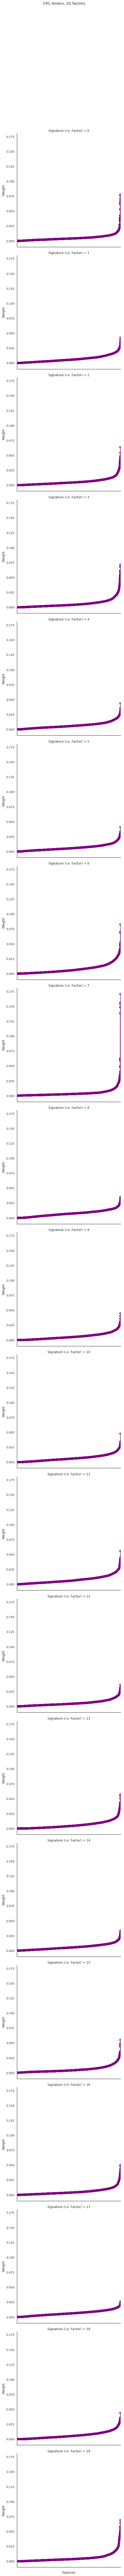

In [5]:
vis_NMF(data_normalized, n_components=20, sort = True, title="CRC 6mers, 20 factors")

(2080, 20)
(20, 121)


/pollard/home/abustion/miniconda3/envs/DL_1118/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/pollard/home/abustion/miniconda3/envs/DL_1118/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


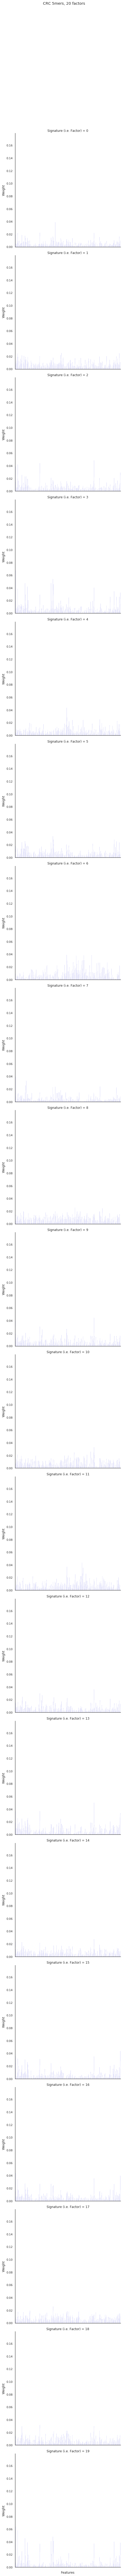

In [6]:
vis_NMF(data_normalized, n_components=20, sort = False, title="CRC 6mers, 20 factors")

# text file output

In [11]:
def top_ten(dataset, kmer_size, n_factor):
    df = pd.read_pickle("/pollard/home/abustion/deep_learning_microbiome/data_AEB/pickled_dfs/['" +
                        dataset +
                        "']" +
                        str(kmer_size) +
                        "mers" + 
                        str(n_factor) +
                        "factors.pickle")
    
    df_output = pd.DataFrame()
    
    for signature in range(0, (n_factor)):
        top = df.loc[df['Signature (i.e. Factor)'] == signature].sort_values(by="Weight", ascending=False).head(n=50)
        df_output = df_output.append(top)
        
    df_output.to_csv("/pollard/home/abustion/deep_learning_microbiome/analysis/NMF/factor_identities/" +
                     dataset + '_' +
                     str(kmer_size) +
                     "mers_" + 
                     str(n_factor) +
                     "NMFfactors.txt", sep = '\t')    
    
    return df_output

In [13]:
top_ten('Zeller_2014', 6, 20)

,Features,Signature (i.e. Factor),Weight
223,AATGAT,0,0.079955
1580,GAATGA,0,0.075178
1082,CATTCA,0,0.072202
2040,TCTGAA,0,0.069409
870,ATTCAG,0,0.067492
799,ATCTGA,0,0.063726
1009,CAGATC,0,0.055131
532,AGATCG,0,0.045411
208,AATCAT,0,0.044214
787,ATCGGA,0,0.040856


In [91]:
for n in (5, 10, 20, 50):
    top_ten('LiverCirrhosis', kmer_size=10, n_factor=n)

In [9]:
def top_ten_for_grepping(dataset, kmer_size, n_factor):
    df = pd.read_pickle("/pollard/home/abustion/deep_learning_microbiome/data_AEB/pickled_dfs/['" +
                        dataset +
                        "']" +
                        str(kmer_size) +
                        "mers" + 
                        str(n_factor) +
                        "factors.pickle")
    
    df_output = pd.DataFrame()
    
    for signature in range(0, (n_factor)):
        top = df.loc[df['Signature (i.e. Factor)'] == signature].sort_values(by="Weight", ascending=False).head(n=10)
        df_output = df_output.append(top)
        
    
    df_output.to_csv("/pollard/home/abustion/deep_learning_microbiome/analysis/NMF/factor_identities/" +
                     dataset + '_' +
                     str(kmer_size) +
                     "mers_" + 
                     str(n_factor) +
                     "NMFfactors_for_grepping.txt", sep = '\t', index=False, header=False)  
                     
    df_output.reset_index(drop=True, inplace=True)
    
    return df_output

In [10]:
top_ten_for_grepping('Zeller_2014', kmer_size=6, n_factor=20)

,Features,Signature (i.e. Factor),Weight
0,AAAGAA,0,0.029394
1,AAACAG,0,0.028210
2,ATATCC,0,0.026127
3,AAAAAG,0,0.024845
4,CTGATC,0,0.024675
5,GAAAAA,0,0.024495
6,GGAAAA,0,0.024331
7,ATGATC,0,0.024314
8,AAAAGA,0,0.023803
9,TGAAAA,0,0.023540


In [106]:
for n in (5, 10, 20, 50):
    top_ten_for_grepping('LiverCirrhosis', kmer_size=10, n_factor=n)

# delete later

In [114]:
df = pd.read_csv("/pollard/home/abustion/deep_learning_microbiome/data_AEB/LiverCirrhosis_PRJEB6337_run_accessions_only.txt",
                sep = '\t')

In [120]:
df.head()

,study_accession,sample_accession,secondary_sample_accession,experiment_accession,run_accession,sample_alias
0,PRJEB6337,SAMEA2581875,ERS475105,ERX491494,ERR526291,HD-1_Run4
1,PRJEB6337,SAMEA2581978,ERS475208,ERX492209,ERR527006,HV1_Run4
2,PRJEB6337,SAMEA2581979,ERS475209,ERX492210,ERR527007,HV10_Run4
3,PRJEB6337,SAMEA2581980,ERS475210,ERX492211,ERR527008,HV11_Run1
4,PRJEB6337,SAMEA2581981,ERS475211,ERX492212,ERR527009,HV11_Run4


In [111]:
df = df['run_accession']

In [113]:
df.to_csv("/pollard/home/abustion/deep_learning_microbiome/data_AEB/LiverCirrhosis_PRJEB6337_run_accessions_only.txt",
         index=False)

In [130]:
for file in os.listdir("/pollard/home/ngarud/shattuck/metagenomic_fastq_files/LiverCirrhosis/combined_fastq_files/"):
    print(file.split('_')[0])

HD-4
HV-3
HV-9
LD-89
LD-79
LD-49
HV-28
HV-18
LD-5
HD-39
LV-2
HD-33
LD-26
LD-16
LD-95
HD-80
LV-21
LV-11
LD-65
LD-55
LV-8
HD-70
HD-40
LD-30
HD-15
HD-25
LD-83
HD-56
HD-66
LD-43
LD-73
HV-12
HV-22
LD-88
LD-48
LD-78
HV-19
HV-29
LD-4
HD-38
LV-3
HD-32
LD-17
LD-27
LD-94
HD-81
LV-10
LV-20
LD-54
LD-64
HD-41
HD-71
LV-9
LD-31
HD-24
HD-14
LD-82
HD-67
HD-57
LD-72
LD-42
HV-23
HV-13
HD-5
HV-2
HV-8
LD-69
LD-59
LV-4
LD-3
HD-19
HD-29
HV-24
HV-14
LD-75
LD-45
HD-60
HD-50
LD-85
HD-23
HD-13
LD-36
HD-46
HD-76
LD-53
LD-63
LV-17
LD-93
LD-10
LD-20
HD-35
LD-9
HV-5
HD-2
HD-8
HV-4
HD-3
HD-9
LD-58
LD-68
LV-5
LD-2
LD-98
HD-28
HD-18
HV-15
HV-25
LD-44
LD-74
HD-51
HD-61
LD-84
HD-12
HD-22
LD-37
HD-77
HD-47
LD-62
LD-52
LV-16
LD-92
LD-21
LD-11
HD-34
LD-8
LD-7
LV-19
HD-78
HD-48
LD-38
LD-81
HD-27
HD-17
LD-32
LD-71
LD-41
HD-64
HD-54
HV-20
HV-10
HD-82
LD-97
LD-14
LD-24
HD-31
LV-13
LV-23
HD-42
HD-72
LD-57
LD-67
HD-6
HV-1
HD-7
LD-6
LV-18
HD-49
HD-79
LV-1
LD-39
LD-80
HD-16
HD-26
LD-33
LD-40
LD-70
HD-55
HD-65
HV-11
HV-21
HD-83
LD-9

# Beta-coefficient distributions

In [204]:
def beta_dist(data_sets, kmer_size, n_factor):

    # Loop over all data sets
    for data_set in data_sets:
        
        data_set = data_set[0]        
    
        # Retrieve diseased data and labels
        allowed_labels = ['0', '1']
        kmer_cnts, accessions, labelz, domain_labels = load_kmer_cnts_jf.load_kmers(kmer_size, data_set, allowed_labels)
        print("LOADED DATASET " + str(data_set[0]) + ": " + str(len(kmer_cnts)) + " SAMPLES")
        labelz=np.asarray(labelz)
        labelz=labelz.astype(np.int)
        
        # Conduct NMF and resave to data_normalized
        if n_factor == 0:
            data_normalized = normalize(kmer_cnts, axis = 1, norm = 'l1')
            data_normalized, labels = shuffle(data_normalized, labelz, random_state=0) 
            x = data_normalized
            y = labels
                    
        else:
            data_normalized = normalize(kmer_cnts, axis = 1, norm = 'l1')
            data_normalized = stats_utils_AEB.NMF_factor(data_normalized, kmer_size, n_components = int(n_factor), 
                                                     title=(str(data_set) + str(kmer_size) + "mers" 
                                                            + str(n_factor) + "factors"))
            data_normalized, labels = shuffle(data_normalized, labelz, random_state=0)
            x = data_normalized
            y = labels
            
        return x, y

In [200]:
data_sets = [
    [['MetaHIT'], ['MetaHIT']],                                                                                                                                                                
    [['Qin_et_al'], ['Qin_et_al']],                                                                                                                                                            
    [['Zeller_2014'], ['Zeller_2014']],                                                                                                                                                        
    #[['LiverCirrhosis'], ['LiverCirrhosis']],                                                                                                                                                  
    #[['Karlsson_2013_no_adapter'], ['Karlsson_2013_no_adapter']],                                                                                                                                                    
    #[['RA_no_adapter'], ['RA_no_adapter']], 
    #[['LeChatelier'], ['LeChatelier']],
    [['Feng'], ['Feng']]
]

MetaHIT
LOADED DATASET MetaHIT: 110 SAMPLES


/pollard/home/abustion/miniconda3/envs/DL_1118/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/pollard/home/abustion/miniconda3/envs/DL_1118/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/pollard/home/abustion/miniconda3/envs/DL_1118/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/pollard/home/abustion/miniconda3/envs/DL_1118/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/pollard/home/abustion/m

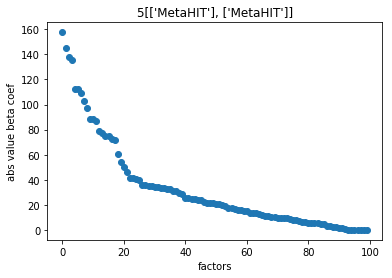

MetaHIT
LOADED DATASET MetaHIT: 110 SAMPLES


/pollard/home/abustion/miniconda3/envs/DL_1118/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/pollard/home/abustion/miniconda3/envs/DL_1118/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/pollard/home/abustion/miniconda3/envs/DL_1118/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/pollard/home/abustion/miniconda3/envs/DL_1118/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/pollard/home/abustion/m

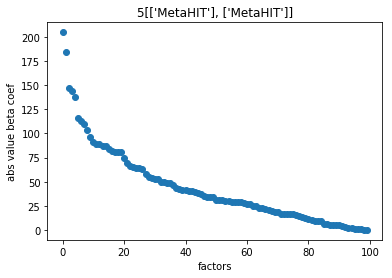

MetaHIT
LOADED DATASET MetaHIT: 110 SAMPLES


/pollard/home/abustion/miniconda3/envs/DL_1118/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/pollard/home/abustion/miniconda3/envs/DL_1118/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/pollard/home/abustion/miniconda3/envs/DL_1118/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/pollard/home/abustion/miniconda3/envs/DL_1118/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/pollard/home/abustion/m

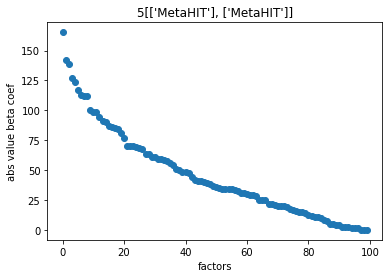

MetaHIT
LOADED DATASET MetaHIT: 110 SAMPLES


/pollard/home/abustion/miniconda3/envs/DL_1118/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/pollard/home/abustion/miniconda3/envs/DL_1118/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/pollard/home/abustion/miniconda3/envs/DL_1118/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/pollard/home/abustion/miniconda3/envs/DL_1118/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/pollard/home/abustion/m

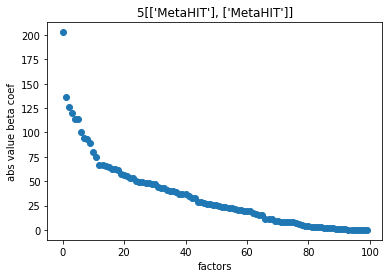

In [211]:
for kmer_size in [10]:
    x, y = beta_dist(data_sets, kmer_size=kmer_size, n_factor=100) 
    
    k_fold = RepeatedStratifiedKFold(n_splits=10, n_repeats=1)
    estimator = LogisticRegressionCV(cv = k_fold, 
                                 scoring= 'accuracy',
                                 max_iter=1000,
                                 penalty = 'l1', 
                                 solver = 'saga', 
                                 n_jobs = 1).fit(x,y)
    
    df = pd.DataFrame(abs(estimator.coef_)).T.sort_values(by = [0],axis=0, ascending=False).reset_index()
    plt.scatter(y = df[0], x= df.index)
    plt.ylabel("abs value beta coef")
    plt.xlabel("factors")
    plt.title(str(kmer_size) + str(data_sets[0]))
    plt.savefig("/pollard/home/abustion/deep_learning_microbiome/analysis/NMF/beta_figures/" + str(kmer_size) + str(data_sets[0]) + ".png")
    plt.show()

In [ ]:
k_fold = RepeatedStratifiedKFold(n_splits=10, n_repeats=1)
estimator = LogisticRegressionCV(cv = k_fold, 
                                 scoring= 'accuracy',
                                 max_iter=1000,
                                 penalty = 'l1', 
                                 solver = 'saga', 
                                 n_jobs = 1).fit(x,y)

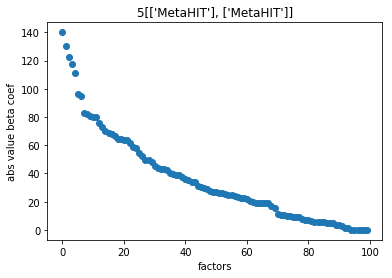

In [174]:
df = pd.DataFrame(abs(estimator.coef_)).T.sort_values(by = [0],axis=0, ascending=False).reset_index()
plt.scatter(y = df[0], x= df.index)
plt.ylabel("abs value beta coef")
plt.xlabel("factors")
plt.title(str(kmer_size) + str(data_sets[0]))
plt.savefig("/pollard/home/abustion/deep_learning_microbiome/analysis/NMF/beta_figures/" + str(kmer_size) + str(data_sets[0]) + ".png")
plt.show()

# Alexandrov 2A

In [21]:
data_sets = [
    #[['MetaHIT'], ['MetaHIT']],                                                                                                                                                                
    #[['Qin_et_al'], ['Qin_et_al']],                                                                                                                                                            
    [['Zeller_2014'], ['Zeller_2014']],                                                                                                                                                        
    #[['LiverCirrhosis'], ['LiverCirrhosis']],                                                                                                                                                  
    #[['Karlsson_2013'], ['Karlsson_2013']],                                                                                                                                                    
    #[['RA'], ['RA']],                                                                                                                                                                          
    #[['Feng'], ['Feng']]
]

In [22]:
def load_data(data_sets, kmer_size):
    
    # Loop over all data sets
    for data_set in data_sets:
        
        data_set = data_set[0]        
    
        # Retrieve diseased data and labels
        allowed_labels = ['0', '1']
        kmer_cnts, accessions, labelz, domain_labels = load_kmer_cnts_jf.load_kmers(kmer_size, data_set, allowed_labels)
        print("LOADED DATASET " + str(data_set[0]) + ": " + str(len(kmer_cnts)) + " SAMPLES")
        labelz=np.asarray(labelz)
        labelz=labelz.astype(np.int)
        data_normalized = normalize(kmer_cnts, axis = 1, norm = 'l1')
        
    
    return data_normalized, labelz

In [23]:
data, labels = load_data(data_sets, kmer_size=5)

Zeller_2014
LOADED DATASET Zeller_2014: 121 SAMPLES


In [39]:
def reconstruction(data_normalized, n_factor):
    #NMF
    model = NMF(
            n_components = n_factor,
            init = 'random',
            solver = 'mu', 
            beta_loss = 'frobenius',
            max_iter = 1000000
        )

    V = data_normalized.T
    W = model.fit_transform(V)
    H = model.components_
    output_for_ML = H.T
    recon_err = model.reconstruction_err_
        
    return recon_err

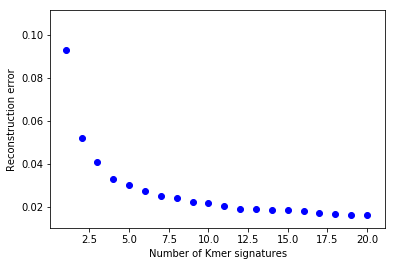

In [41]:
#Initialize figure
plt.figure()
plt.xlabel('Number of Kmer signatures')
plt.ylabel('Reconstruction error')

#Reconstruction error versus number of components
no_components = 20
for i in range(1, no_components+1):
    recon_err = reconstruction(data, n_factor=i)
    plt.scatter(i, recon_err, color = 'b')
    
plt.show()

In [51]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
Kmeans.fit(NMFed_data, n_clusters=i)

In [43]:
silhouette_score(Kmeaned_data, labels)

0.08072298067212223

In [63]:
def reproducibility(data_normalized, n_factor):
    #NMF
    model = NMF(
            n_components = n_factor,
            init = 'random',
            solver = 'mu', 
            beta_loss = 'frobenius',
            max_iter = 1000000
        )

    V = data_normalized.T
    W = model.fit_transform(V)
    H = model.components_
    output_for_ML = H.T
    
    estimator = KMeans(n_clusters=n_factor)
    estimator.fit(output_for_ML)
    score = silhouette_score(output_for_ML, estimator.labels_, metric='euclidean')
    
    return score

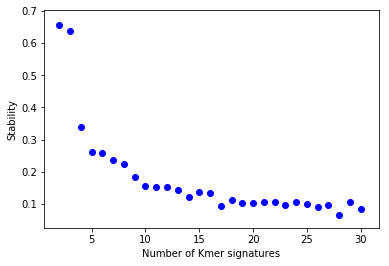

In [64]:
#Initialize figure
plt.figure()
plt.xlabel('Number of Kmer signatures')
plt.ylabel('Stability')

#Reconstruction error versus number of components
no_components = 30
for i in range(2, no_components+1):
    repro = reproducibility(data, n_factor=i)
    plt.scatter(i, repro, color = 'b')
    
plt.show()